In [1]:
import sys
import pprint, re
from os import listdir
from os.path import isfile, join
import psycopg2
import pandas as pd
import pickle
import pprint as pp
import re
import numpy as np
import statistics as s
import math
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect(database = "postgres", user = "postgres", password = "123123", host = "localhost", port = "5432")
print ("Opened database successfully")

Opened database successfully


In [3]:
conn.autocommit = True
curs = conn.cursor()
SQL_STATEMENT = "COPY %s FROM STDIN WITH CSV HEADER"

#table = 'CREATE TABLE aka_name (id integer NOT NULL PRIMARY KEY,person_id integer NOT NULL,name character varying,imdb_index character varying(3),name_pcode_cf character varying(11),name_pcode_nf character varying(11),surname_pcode character varying(11),md5sum character varying(65));'
# table='''
#     CREATE TABLE person_info (
#     id integer NOT NULL PRIMARY KEY,
#     person_id integer NOT NULL,
#     info_type_id integer NOT NULL,
#     info character varying NOT NULL,
#     note character varying
# );
# '''
# curs.execute(table)

In [4]:
def process_file(conn, table_name, file_object):
    cursor = conn.cursor()
    cursor.copy_expert(sql=SQL_STATEMENT % table_name, file=file_object)
    conn.commit()
    cursor.close()

In [5]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

def delchars(chars, table):
    for i in range(len(table)):
        for j, value in enumerate(table[i][1]):
            table[i][1][j]= table[i][1][j].translate(str.maketrans('', '', chars))
        #pp.pprint(table[i][1])
def elimDupe(splitString, beforeSplit, table):
    if len(splitString) > 1 and table.count(splitString[0]) == 0: table.append(splitString[0])
    elif len(splitString) == 1: table.append(beforeSplit)

In [6]:
def extractFeaturesPostgreS(tableOld, tMap, TMap):
    featuresRaw = []
    minC, maxC, minR, maxR = 999999999999, -1, 999999999999, -1
    for i in range(len(tableOld)):
        currFeatures = []
        for j in range(len(tableOld[i][1])):
            for k, (key, Value) in enumerate(tMap.items()):
                if tableOld[i][1][j].find(key) > -1:
                    opType = Value
                    break
                else: continue
            tableUsed = findScanTable(tableOld[i][1][j], TMap)
            if tableOld[i][1][j].find('cost=') > -1 and tableOld[i][1][j].find('rows=') > -1:
                
                estC = tableOld[i][1][j][tableOld[i][1][j].find('cost=') + 5 : tableOld[i][1][j].find('rows=')].split('..')
                estR = tableOld[i][1][j][tableOld[i][1][j].find('rows=') + 5 : tableOld[i][1][j].find('width=')]
                minC = updateMin(minC, float(estC[1]))
                maxC = updateMax(maxC, float(estC[1]))
                minR = updateMin(minR, float(estR))
                maxR = updateMax(maxR, float(estR))
                currFeatures.append([opType, tableUsed, float(estC[1]), float(estR)])
        featuresRaw.append([tableOld[i][0], currFeatures])
    return featuresRaw, minC, maxC, minR, maxR

In [7]:
def findScanTable(opString, tables):
    if opString.find('Scanon') > -1 or opString.find('Scanusing') > -1:
        #tableStr = opString[opString.find('Scanon') + 6 : re.search(r'\W+', opString).start()]
        for i, (key, value) in enumerate(tables.items()):
            if opString.find(key) > -1: return value
    return -1

def getOccurances(entry, data, tMap, ind = 1):
    count = 0
    for i in range(len(data)):
        for j in range(len(data[i][1])):
            if data[i][1][j][ind] == entry: count += 1
    return count

In [8]:
# replace costs and rows with their orders of magnitude
def fillEmptyTableDataOOD(table):
    for i in range(len(table)):
        currTable = -1
        for j in reversed(table[i][1]):
            if not j[1] == -1:
                currTable = j[1]
            else:
                j[1] = currTable
            # tables (256/5)
            j[1] = int((j[1] + 1) * 51)
            # costs (256/6)
            j[2] = int(orderOfMagnitude(j[2]) * 42.66)
            # rows (256/8)
            j[3] = int(orderOfMagnitude(j[3]) * 32)

In [9]:
def getLabelTime(tableOld):
    Labels = []
    for i in range(len(tableOld)):
        if tableOld[i][1][0].find('actualtime=') > -1 and tableOld[i][1][0].rfind('rows=') > -1:
            label = tableOld[i][1][0][tableOld[i][1][0].find('actualtime=') + 11 : tableOld[i][1][0].rfind('rows=')].split('..')
            Labels.append([tableOld[i][0], float(label[1])])
    return Labels

def getLabelRows(tableOld):
    Labels = []
    for i in range(len(tableOld)):
        if tableOld[i][1][0].find('actualtime=') > -1 and tableOld[i][1][0].rfind('rows=') > -1:
            label = tableOld[i][1][0][tableOld[i][1][0].rfind('rows=') + 5 : tableOld[i][1][0].rfind('loops=')]
            Labels.append([tableOld[i][0], float(label)])
    return Labels

In [10]:
def getMinMaxLabel(labels):
    return np.amin(labels.astype(float)), np.amax(labels.astype(float))

def normalizeLabel(labels):
    amin, amax = getMinMaxLabel(labels)
    print(amin, amax)
    for i, val in enumerate(labels):
        labels[i] = (val.astype(float)-amin) / (amax-amin)

In [11]:
# possible feature values [1, 2, 3]

def printFeatureInfo(feature, data):
    res = []
    for i in range(len(data)):
        for j in range(len(data[i][1])):
            res.append(float(data[i][1][j][feature]))
    res = pd.DataFrame(res)
    res.describe()
    return res

In [12]:
def updateMin(currMin, val):
    if currMin < val:
        return currMin
    else: return val

def updateMax(currMax, val):
    if currMax > val:
        return currMax
    else: return val

In [13]:
# datasets already loaded in postgres (some are not mentioned in synthetic data):
fulltableMap = {
    'aka_name' : 0,
    'aka_title' : 1,
    'cast_info' : 2,
    'char_name' : 3,
    'comp_cast_type' : 4,
    'company_name' : 5,
    'company_type' : 6,
    'complete_cast' : 7,
    'info_type' : 8,
    'keyword' : 9,
    'kind_type' : 10,
    'link_type' :11,
    'movie_companies' : 12,
    'movie_info' : 13,
    'movie_info_idx' : 14,
    'movie_keyword' : 15,
    'movie_link' : 16,
    'name' : 17,
    'person_info' : 18,
    'role_type' : 19,
    'title' : 20
}

# arranged in size, ascending order
tableMap = {
    'title' : 0,
    'movie_companies' : 1,
    'keyword' : 2,
    'movie_info' : 3,
    'cast_info' : 4
}

In [14]:
# file_name = 'aka_title'
# data_path = f'datasets/job/{file_name}.csv'
# with open(data_path, 'r', encoding="utf-8") as file:
#     process_file(conn, file_name, file)
#     #curs.copy_expert("COPY company_name FROM stdin WITH CSV HEADER",file)
#     file.close()

In [16]:
p = pp.PrettyPrinter()

jobs = []
f = open("queries/synthetic.sql", "r")
while True:
    temp = f.readline()
    if temp == 'end' : break
    temp = temp.replace(';\n', '')
    jobs.append(temp)
f.close()

save_file = 'data_postgres.pkl'

In [17]:
# execute queries and save to file

# for i in range(len(jobs)):
#     #data = []
#     curs.execute(curs.mogrify('explain analyze ' + jobs[i]))
#     analyze_fetched = curs.fetchall()
#     #data.append([jobs[i], analyze_fetched])
#     with open(save_file, 'ab') as file:
#         pickle.dump([jobs[i], analyze_fetched], file)
# #     for i in range(len(analyze_fetched)):
# #         print(analyze_fetched[i])

In [20]:
test=[]
with open(save_file, "rb") as f:
    while True:
        try:
            current_id=pickle.load(f)
            test.append(current_id)
        except EOFError:
            print('end')
            break
test = flatten(test)

end


In [21]:
print(len(test))

5000


In [22]:
for i in range(len(test)):
    test[i][1] = flatten(test[i][1])
    for j, value in enumerate(test[i][1]):
        test[i][1][j] = test[i][1][j].strip(" \n',")
        #print(test[i][1][j])

In [23]:
# chars = '+- '
delchars('+- ', test)

In [24]:
tokens = []
nestedTokens = []
for i in range(len(test)):
    for j, value in enumerate(test[i][1]):
        getPref = test[i][1][j][0:re.search(r'\W+', test[i][1][j]).start()]
        getNestedPref = test[i][1][j][1:test[i][1][j].find('(')]
        if getPref == '' and nestedTokens.count(getNestedPref) == 0:
            excludeTable = re.split('on|using', getNestedPref)
            elimDupe(excludeTable, getNestedPref, nestedTokens)
                
        if tokens.count(getPref) == 0:  
#             excludeTable = re.split('using', getPref)
            if getPref.find('Scanon') > -1:
                excludeTable = re.split('on', getPref)
            else: excludeTable = re.split('using', getPref)
            elimDupe(excludeTable, getPref, tokens)

In [25]:
# print('\nNested Tokens:\n')
# pp.pprint(nestedTokens)
# print('\nTokens: \n')
# pp.pprint(tokens)

In [26]:
tokenMap = {
    'Gather': 9,
    'ParallelSeqScan': 4,
    'ParallelHashJoin': 8,
    'HashJoin': 10,
    'SeqScan': 7,
    'ParallelHash': 3,
    'Hash': 6,
    'NestedLoop': 5,
    'IndexScan': 2,
    'Memoize': 1,
}
for i, (key, value) in enumerate(tokenMap.items()):
    print(key, value)

Gather 9
ParallelSeqScan 4
ParallelHashJoin 8
HashJoin 10
SeqScan 7
ParallelHash 3
Hash 6
NestedLoop 5
IndexScan 2
Memoize 1


In [27]:
delchars('>', test)

In [28]:
result, minCosts, maxCosts, minRows, maxRows = extractFeaturesPostgreS(test, tokenMap, tableMap)
result2, minCosts, maxCosts, minRows, maxRows = extractFeaturesPostgreS(test, tokenMap, tableMap)

In [29]:
for i, (key, value) in enumerate(tableMap.items()):
    c = getOccurances(value, result, tableMap)
    print(f'{key} : {c}')

title : 3766
movie_companies : 1548
keyword : 1873
movie_info : 2027
cast_info : 1827


In [30]:
for i, (key, value) in enumerate(tokenMap.items()):
    c = getOccurances(value, result, tokenMap, ind = 0)
    print(f'{key} : {c}')

Gather : 3655
ParallelSeqScan : 7976
ParallelHashJoin : 4321
HashJoin : 931
SeqScan : 2276
ParallelHash : 4321
Hash : 931
NestedLoop : 789
IndexScan : 789
Memoize : 54


In [31]:
fillEmptyTableDataOOD(result)
print(result[2][1])

[[10, 255, 255, 224], [7, 255, 213, 224], [6, 51, 170, 192], [7, 51, 170, 192]]


In [32]:
# costs: 2, rows: 3
res = printFeatureInfo(2, result2)
res.describe()

,0
count,2.604300e+04
mean,2.332564e+05
std,3.379958e+05
min,4.600000e-01
25%,4.995794e+04
50%,8.100313e+04
75%,3.113732e+05
max,5.526418e+06


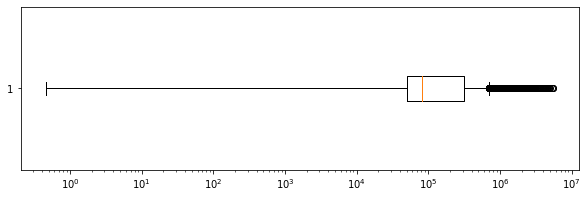

In [33]:
fig, ax=plt.subplots(figsize = (10,3))
#ax.figsize(20,10)
ax.boxplot(res, vert = False)
ax.set_xscale('log')
plt.show()

In [34]:
labelT = np.array(getLabelTime(test))
labelR = np.array(getLabelRows(test))

In [35]:
normalizeLabel(labelT[:,1])
print(getMinMaxLabel(labelT[:,1]))
normalizeLabel(labelR[:,1])
print(getMinMaxLabel(labelR[:,1]))

65.808 185985.584
(0.0, 1.0)
1.0 424508167.0
(0.0, 1.0)


In [36]:
labelDF = pd.DataFrame(labelT, columns = ['query','label'])
labelDF.head()
labelDF.to_csv('labels_rowsT.csv', index = False)

C:\Users\Yuhan\AppData\Local\Temp\ipykernel_15736\56692877.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.array(result2)


<function matplotlib.pyplot.show(close=None, block=None)>

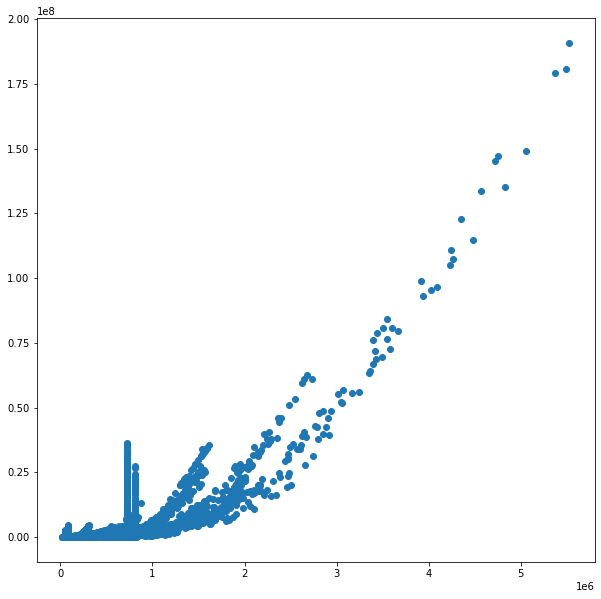

In [37]:
# visualize costs vs rows for estimated postgres values
temp = np.array(result2)
x = []
y= []
for i in range(len(result2)):
    x.append(result2[i][1][0][2])
    y.append(result2[i][1][0][3])

plt.figure(figsize = (10,10))
plt.scatter(np.array(x),y)
plt.show

START OF IMAGE PREPROCESSING
---
---

In [45]:
import matplotlib.image as img
import os, csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import *
import tensorflow_addons as tfa

D:\Anaconda\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201110). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [47]:
path = 'image_data'
if not os.path.exists(path):
    os.makedirs(path)

In [48]:
# Image RGB channels: R = tables, G = estimated costs, B = estimated rows

def dataToImage(data, save_path):
    imageList = []
    maxDim = -1
    for i in range(len(data)): #len(data)
        image = []
        if len(data[i][1]) > maxDim: maxDim = len(data[i][1])
        for j in range(len(data[i][1])):
            row = []
            for k in range(data[i][1][j][0]):
                row.append([data[i][1][j][1], data[i][1][j][2], data[i][1][j][3]])
            if k < 9:
                for a in range(9 - k):
                    row.append([0, 0, 0])
            image.append(row)
        imageList.append(image)
    for i in range(len(data)):
        padImage(imageList[i], maxDim)
        #pp.pprint(imageList[i])
        saveImage(imageList[i], i, path = save_path)
        #pp.pprint(image)
    return maxDim, imageList

In [49]:
def padImage(image, maxRows):
    for i in range(len(image)):
        #print(len(image), maxRows)
        if len(image) < maxRows:
            for j in range(maxRows - len(image)):
                row = []
                for k in range(10):
                    row.append([0, 0, 0])
                image.append(row)
        #pp.pprint(image[i])
def saveImage(image, name, path = 'image_data'):
    image = np.array(image)
    im = Image.fromarray(image.astype(np.uint8))
    im.save(f'{path}/query_{name}.png')
    #img.imsave(, image)
def saveImage_im(image, name, path = 'image_data'):
    cv2.imwrite(f'{path}/{name}.png', image)

In [50]:
mDim, imageL = dataToImage(result, path)
#pp.pprint(imageL)

In [51]:
#pp.pprint(result[:3])
num = np.array(imageL[0])
print(num.shape)
with open('labels_rows.csv', newline='') as csvfile:
    labels = list(csv.reader(csvfile))

(8, 10, 3)


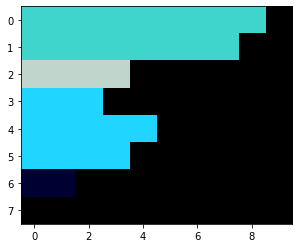

In [52]:
currImage = cv2.imread(f'{path}/query_3.png') 
plt.imshow(currImage)

In [53]:
# use labelT for label = actual time, labelR for label = actual rows

data_labels = pd.DataFrame(labelT, columns = ['query', 'label'])
data_labels['index'] = data_labels.index
data_labels.head()

,query,label,index
0,SELECT * FROM cast_info AS ci WHERE ci.person...,0.006720032838249546,0
1,"SELECT * FROM title AS t, movie_info AS mi WH...",0.006958920819698061,1
2,"SELECT * FROM title AS t, cast_info AS ci WHE...",0.13665377910093868,2
3,"SELECT * FROM title AS t, cast_info AS ci, mo...",0.012720174533773103,3
4,"SELECT * FROM title AS t, cast_info AS ci, mo...",0.017440683663474295,4


In [54]:
labels = data_labels[['index','label']].astype(float)
labels['index'] = data_labels['index'].astype(int)
labels.head()

labels = data_labels['label'].astype(float)

In [55]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)
labels.describe()

count   5000.000000000
mean       0.024950807
std        0.061983458
min        0.000000000
25%        0.001870639
50%        0.008433148
75%        0.019210919
max        1.000000000
Name: label, dtype: float64

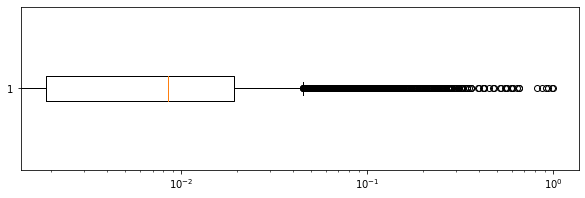

In [56]:
fig, ax=plt.subplots(figsize = (10,3))
#ax.figsize(20,10)
ax.boxplot(labels, vert = False)
ax.set_xscale('log')
plt.show()

In [57]:
x_train = []
y_train = []

xdim = 30
ydim = 24
files = os.listdir("image_data")
for i in range(len(files)):    # Directory
    img = cv2.imread('image_data/query_{}.png'.format(i), cv2.IMREAD_UNCHANGED)
    x_train.append(cv2.resize(img, (xdim, ydim), interpolation = cv2.INTER_AREA))
    
y_train = labels
x_train = np.array(x_train)

print(x_train.shape)
print(y_train.shape)

(5000, 24, 30, 3)
(5000,)


In [58]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [59]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3000, 24, 30, 3) (3000,)
(1000, 24, 30, 3) (1000,)
(1000, 24, 30, 3) (1000,)


END OF PREPROCESSING
---
---

In [38]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time
import seaborn as sb

In [70]:
def getModel():

    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape = (24, 30, 3)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.1))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))

    model.add(Dense(1, activation='linear'))


    model.compile(loss='mean_absolute_error', 
                      optimizer='adam',
                      metrics=['mse']
                     )

    model.summary()
    return model


In [71]:
# Generate model
def get_model():
    model = keras.Sequential([
        keras.layers.Dense(hidden_layer, use_bias = True, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(decay_beta)),
        keras.layers.Dense(1)
    ])

    SGD_opt = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=SGD_opt,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    return model

In [73]:
# Train model

def fit_model(train_X, train_Y, test_X, test_Y, epochs, batch_size, model, isCallback):
    if isCallback:
        # stops training when there is no observed improvement in mse for 5 epochs
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_mse', min_delta = 0.0001,patience=10)
    else:
        callback = timeCallback()
    history = model.fit(train_X, train_Y,
                        epochs=epochs,
                        callbacks = [callback],
                        verbose = 2,
                        batch_size=batch_size,
                        validation_data = (test_X, test_Y),
                        shuffle=True)
    #timeTaken = np.mean(timeTaken.logs)
    return history, model

In [74]:
# Plot mean squared error for training and test datasets against number of epochs
def plot_mse(mse, mse_test, epochs, bound = False):
    plt.clf()
    plt.figure(figsize = (15,8))
    plt.plot(range(epochs), mse)
    plt.plot(range(epochs), mse_test)
    plt.xlabel('No. epochs')
    plt.ylabel('mse')
    plt.legend(['train mse', 'test mse'])
    plt.title('mse of train and test data')
    if bound:
        plt.ylim(0, 0.1)

In [75]:
# Function for timing duration per epoch
class timeCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.logs=[]

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(time.time() - self.epoch_start)

In [39]:
# Hyperparameters

NUM_CLASSES = 7

epochs = 100
batch_size = 16

seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [76]:
model = getModel()
history, model = fit_model(x_train, y_train, x_val, y_val, epochs, batch_size, model, False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 28, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9856)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               5046784   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

Epoch 73/100
188/188 - 1s - loss: 0.0098 - mse: 0.0020 - val_loss: 0.0079 - val_mse: 5.6972e-04
Epoch 74/100
188/188 - 1s - loss: 0.0090 - mse: 0.0012 - val_loss: 0.0082 - val_mse: 8.2021e-04
Epoch 75/100
188/188 - 1s - loss: 0.0094 - mse: 0.0011 - val_loss: 0.0083 - val_mse: 6.5732e-04
Epoch 76/100
188/188 - 1s - loss: 0.0096 - mse: 0.0012 - val_loss: 0.0085 - val_mse: 6.5832e-04
Epoch 77/100
188/188 - 1s - loss: 0.0088 - mse: 8.4982e-04 - val_loss: 0.0086 - val_mse: 6.9899e-04
Epoch 78/100
188/188 - 1s - loss: 0.0090 - mse: 9.7358e-04 - val_loss: 0.0079 - val_mse: 7.2006e-04
Epoch 79/100
188/188 - 1s - loss: 0.0089 - mse: 8.9888e-04 - val_loss: 0.0081 - val_mse: 5.3451e-04
Epoch 80/100
188/188 - 1s - loss: 0.0089 - mse: 9.7862e-04 - val_loss: 0.0084 - val_mse: 8.9302e-04
Epoch 81/100
188/188 - 1s - loss: 0.0086 - mse: 8.5931e-04 - val_loss: 0.0084 - val_mse: 9.3909e-04
Epoch 82/100
188/188 - 1s - loss: 0.0088 - mse: 9.2677e-04 - val_loss: 0.0078 - val_mse: 5.7955e-04
Epoch 83/100
188

In [79]:
score = model.evaluate(x_val, y_val, verbose=0)
print(score)

[0.008493012748658657, 0.0006599205662496388]


<function matplotlib.pyplot.show(close=None, block=None)>

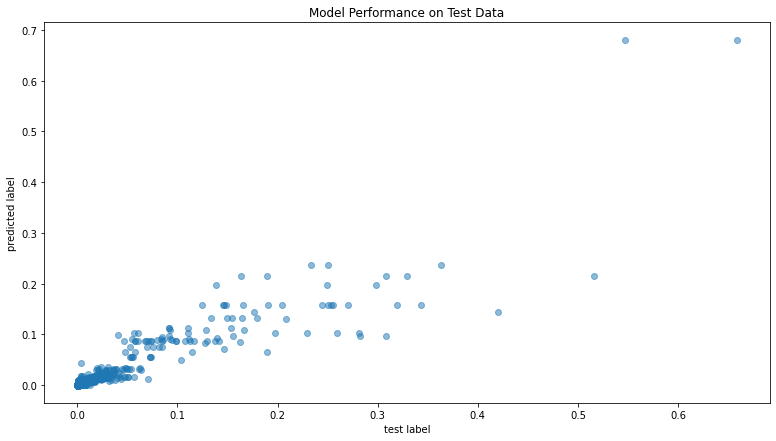

In [81]:
preds = model.predict(x_test)
preds = preds[:,0]
plt.figure(figsize=(13,7))
plt.scatter(y_test, preds, alpha = 0.5)
# plt.xlim(0,0.1)
# plt.ylim(0,0.1)
plt.xlabel('test label')
plt.ylabel('predicted label')
plt.title('Model Performance on Test Data')
plt.show

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


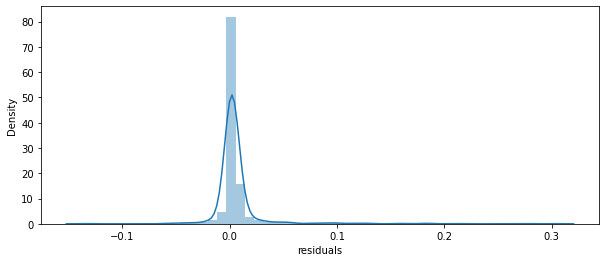

In [82]:
residuals = y_test - preds
fig, ax = plt.subplots(figsize=(10,4))
a = sb.distplot(residuals, ax=ax)
plt.xlabel('residuals')
plt.show()

In [83]:
r2_score(y_test, preds)

0.8097636000705107

In [10]:
#model.save('model')

<Figure size 432x288 with 0 Axes>

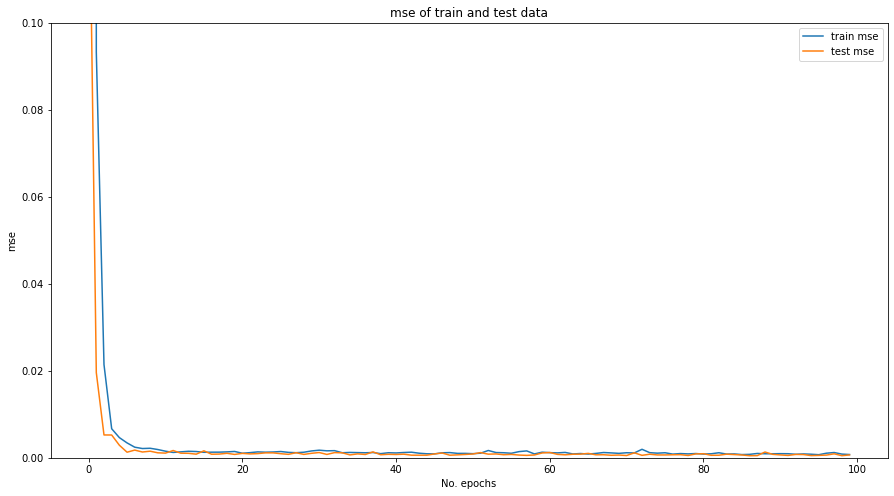

In [84]:
plot_mse(history.history['mse'], history.history['val_mse'], len(history.history['mse']), True)

In [ ]:
# Postgres residuals

residual = labels - y
fig, ax = plt.subplots(figsize=(10,4))
a = sb.distplot(residual, ax=ax)
plt.xlabel('residuals')
plt.show()
#sb.distplot(residual)

In [ ]:
r2_score(labels, y)